In [118]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os

from src.utils import download_dataset

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

In [11]:
data_path = 'data'
csv_fn = os.path.join(data_path, 'data_science_dataset_test_task.csv')

if not os.path.isfile(csv_fn):
    print('Dataset not found, downloading dataset...')
    os.mkdir(data_path)
    download_dataset(csv_fn)
    
print('Dataset path: ', csv_fn)

Dataset not found, downloading dataset...
Dataset path:  data\data_science_dataset_test_task.csv


Поставленная задача - бинарная классификация, таргет определяет продлит ли пользователь подписку или нет.

In [13]:
df = pd.read_csv(csv_fn)

print('Dataframe shape: ', df.shape)
df.head(10)

Dataframe shape:  (516180, 31)


,Unnamed: 0,current_dt,user_id,scheduled_dt,root_order_id,gender,age,os_family,lt_user,hours_after_reg_buy,...,was_3ds,card_type,card_country_code,success_orders,not_success_orders,insufficients,root_gross,not_root_gross,old_model_probability,is_success
0,37,2019-05-12 05:40:15.355095,13801584,2019-06-09 00:00:00.000000,96601292,f,43,11,2,0,...,0,2.0,154,2,0,0,29.17,6.81,0.512364,1
1,45,2019-06-07 08:10:15.982701,16144816,2019-06-09 00:00:00.000000,116843195,f,25,11,4,76,...,0,2.0,3,2,1,1,0.47,0.46,0.133615,1
2,46,2019-06-07 08:10:15.982701,16467614,2019-06-09 00:00:00.000000,116847635,f,45,11,1,0,...,0,2.0,1,2,1,0,0.48,6.67,0.481923,0
3,47,2019-06-08 03:10:13.314904,16467614,2019-06-09 00:00:00.000000,116847635,f,45,11,2,0,...,0,2.0,1,2,1,0,0.48,6.67,0.485032,0
4,51,2019-06-07 08:10:15.982701,16482460,2019-06-09 00:00:00.000000,116953235,m,45,11,1,0,...,0,2.0,1,1,1,1,0.48,0.00,0.114275,0
5,52,2019-06-08 03:10:13.314904,16482460,2019-06-09 00:00:00.000000,116953235,m,45,11,2,0,...,0,2.0,1,1,1,1,0.48,0.00,0.114605,0
6,55,2019-06-07 08:10:15.982701,16493856,2019-06-09 00:00:00.000000,117041055,m,41,11,1,0,...,0,2.0,1,1,0,0,0.48,0.00,0.304778,1
7,56,2019-06-08 03:10:13.314904,16493856,2019-06-09 00:00:00.000000,117041055,m,41,11,2,0,...,0,2.0,1,1,0,0,0.48,0.00,0.305821,1
8,57,2019-06-07 08:10:15.982701,16461292,2019-06-09 00:00:00.000000,117058275,m,34,11,1,8,...,0,2.0,1,2,0,0,0.48,6.67,0.429660,1
9,58,2019-06-08 03:10:13.314904,16461292,2019-06-09 00:00:00.000000,117058275,m,34,11,2,8,...,0,2.0,1,2,0,0,0.48,6.67,0.433980,1


### EDA

Для начала посмотрим на признаки, их распределения, взаимосвязь с таргетом. Описание признаков, предоставленное вместе с данными:

| Column name             | Data type   | Description                                                           |
| ----------------------- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| current\_dt             | timestamp   | в какой момент времени была собрана информация                                                                                                                                                         |
| user\_id                | id          | уникальный индефикатор пользователя                                                                                                                                                                    |
| scheduled\_dt           | timestamp   | дата на которую запланировано автопродление                                                                                                                                                            |
| root\_order\_id         | id          | уникальный индефикатор подписки                                                                                                                                                                        |
| gender                  | categorical | пол пользователя                                                                                                                                                                                       |
| age                     | categorical | возраст пользователя                                                                                                                                                                                   |
| os\_family              | categorical | операционная система пользователя                                                                                                                                                                      |
| lt\_user                | nominal     | lifetime пользователя                                                                                                                                                                                  |
| hours\_after\_reg\_buy  | nominal     | через сколько часов после регистрации пользователь оформил подписку                                                                                                                                    |
| country\_code           | categorical | страна пользователя                                                                                                                                                                                    |
| phone                   | categorical | марка телефона пользователя                                                                                                                                                                            |
| cpa                     | nominal     | СPA по которому был привлечен пользователь                                                                                                                                                             |
| retry\_number           | nominal     | номер попытки автопродлить подписку                                                                                                                                                                    |
| period                  | categorical | на какой период оформлена подписка                                                                                                                                                                     |
| gross                   | nominal     | сколько стоит продление подписки                                                                                                                                                                       |
| currency\_id            | categorical | валюта в какой оформлена подписка                                                                                                                                                                      |
| discount                | nominal     | размер скидки на продление                                                                                                                                                                             |
| psp                     | categorical | платежный шлюз                                                                                                                                                                                         |
| last\_response\_code    | categorical | при неудачных попытках автопродлить подписку платежный сервис отдает причину неудачи (response\_code). last\_response\_code говорит какой был ответ при прошлой попытке продлить подписку пользователю |
| bank                    | categorical | банк в котором оформлена карта пользователя                                                                                                                                                            |
| was\_3ds                | binary      | проходило ли оформление подписки через 3D Secure                                                                                                                                                       |
| card\_type              | categorical | тип карты                                                                                                                                                                                              |
| card\_country\_code     | categorical | страна оформления карты                                                                                                                                                                                |
| success\_orders         | nominal     | количество успешных оплат пользователя                                                                                                                                                                 |
| not\_success\_orders    | nominal     | количество не успешных оплат пользователя                                                                                                                                                              |
| insufficients           | nominal     | количество не успешных оплат пользователя по причине недостаточного количества средств на карте                                                                                                        |
| root\_gross             | nominal     | на какую сумму пользователь уже оформил данную подписку                                                                                                                                                |
| not\_root\_gross        | nominal     | какую сумму пользователь потратил без учета данной подписки                                                                                                                                            |
| old\_model\_probability |             | вероятность успешного продления данной подписки, которое отдает старая модель                                                                                                                          |
| is\_success             |             | результат - произошло ли продление подписки                                                                                                                                                            |


В датасете помимо вышеперечисленных 30 признаков есть также столбец `Unnamed: 0`, скорее всего этот столбец - индексы строк датасета из которого бралась эта подвыборка; он остался из за того что при сохранении данных в файл в функцию `to_csv()` не было передано значение параметра `index=False`. Данный столбец можно дропнуть.

Категориальные столбцы в последствии нужно закодировать можно использовать несколько способов:
1. Для категорий которые можно проранжировать можно использовать Ordinal Encoding (если есть категории low, medium, high они будут закодированы 0, 1, 2 соответственно)
2. Можно использовать OneHotEncoding, что создаст определенное количество бинарных столбцов (если брать пример выше, будут созданы 3 столбца category_low, category_medium, category_high, и для значения категории medium вектор будет 0, 1, 0; изначальный столбец category будет дропнут; в зависимости от реализации один из столбоцов с категориями может быть дропнут, к примеру если category_low и category_medium соответствуют значениям 0, 0 то можно однозначно сказать что category_high будет равен 1, и по сути нам не нужен этот столбец). Это расширяет пространство признаков, что может усложнить обучаемость некоторых моделей (к примеру SVM). Может возникать curse of dimensionality.
3. Можно закодировать категории чем то вроде TargetEncoding, который меняет категорию на частоту ее встречаемости в зависимости от таргета
4. Можно попробовать более экзотические вещи, например конвертировать все категориальные значения объекта в строку, затем смоделировать векторное представление используя LSA. Или использовать нечто вроде group2vec. Не уверен что такие способы зайдут конкретно для данной задачи и данных, но попробовать стоит. 

In [28]:
df.info()

Columns with NaN values:  ['phone' 'bank' 'card_type']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516180 entries, 0 to 516179
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             516180 non-null  int64  
 1   current_dt             516180 non-null  object 
 2   user_id                516180 non-null  int64  
 3   scheduled_dt           516180 non-null  object 
 4   root_order_id          516180 non-null  int64  
 5   gender                 516180 non-null  object 
 6   age                    516180 non-null  int64  
 7   os_family              516180 non-null  int64  
 8   lt_user                516180 non-null  int64  
 9   hours_after_reg_buy    516180 non-null  int64  
 10  country_code           516180 non-null  int64  
 11  phone                  516165 non-null  float64
 12  cpa                    516180 non-null  float64
 13  retry_number           516180 no

In [32]:
columns_with_na = df.columns[df.isna().sum() > 0].values
print('Columns with NaN values: ', columns_with_na)
print('Missing value count:\n')

df[columns_with_na].isna().sum()

Columns with NaN values:  ['phone' 'bank' 'card_type']
Missing value count:



phone           15
bank         33623
card_type    24862
dtype: int64

При обработке данных необходимо будет вставить пропущенные значения в датафрейм, так как многие алгоритмы машинного обучения не могут работать с пропущенными значениями. Если использовать модели основанные на деревьях решений, данный момент можно опустить.

В дальнейшем буду тестировать разные модели, поэтому заполню пропущенные значения, предлагаю попробовать несколько разных вариантов и посмотреть какой даст лучший результат:
1. Так как записей с пропущенным номером телефона немного, можно попробовать дропнуть эти строки
2. Вставим константные значения 0, среднего, медианы, моды (для категориальных)
3. Вставим значения вне диапазона (к примеру -1 для признака, значения которых лежат от 0 до +бесконечности) и создадим столбец, показывающий было ли значение пропущено.
4. Нормализуем данные и подберем пропущенные значения методом ближайших соседей.

In [53]:
numerical_cols = ['age', 'hours_after_reg_buy',
                  'retry_number', 'gross', 'discount',
                  'success_orders', 'not_success_orders', 'insufficients',
                  'root_gross', 'not_root_gross', 'old_model_probability']

categorical_cols = ['gender', 'os_family', 'lt_user', 'country_code',  'period',
                    'phone', 'cpa', 'currency_id',
                    'psp', 'last_response_code', 'bank', 'was_3ds', 'card_type', 'card_country_code']

In [54]:
df[numerical_cols].describe()

,age,hours_after_reg_buy,retry_number,gross,discount,success_orders,not_success_orders,insufficients,root_gross,not_root_gross,old_model_probability
count,516180.000000,516180.000000,516180.000000,516180.000000,516180.000000,516180.000000,516180.000000,516180.000000,516180.000000,516180.000000,516180.000000
mean,36.143429,6.061773,0.335137,18.057013,12.769819,1.275948,1.022021,0.785519,1.354549,1.624203,0.212580
std,10.664965,14.878203,0.582285,10.276962,23.121576,0.503841,1.300843,1.023739,3.628096,5.235403,0.146113
min,18.000000,0.000000,0.000000,1.999696,0.000000,1.000000,0.000000,0.000000,0.260000,0.000000,0.001098
25%,28.000000,0.000000,0.000000,10.097759,0.000000,1.000000,0.000000,0.000000,0.460000,0.000000,0.092350
50%,36.000000,0.000000,0.000000,17.952210,0.000000,1.000000,1.000000,0.000000,0.480000,0.000000,0.162509
75%,43.000000,2.000000,1.000000,20.040278,0.000000,2.000000,2.000000,1.000000,0.540000,0.000000,0.312187
max,86.000000,110.000000,3.000000,60.807688,75.000000,13.000000,72.000000,30.000000,61.850000,502.860000,0.965888


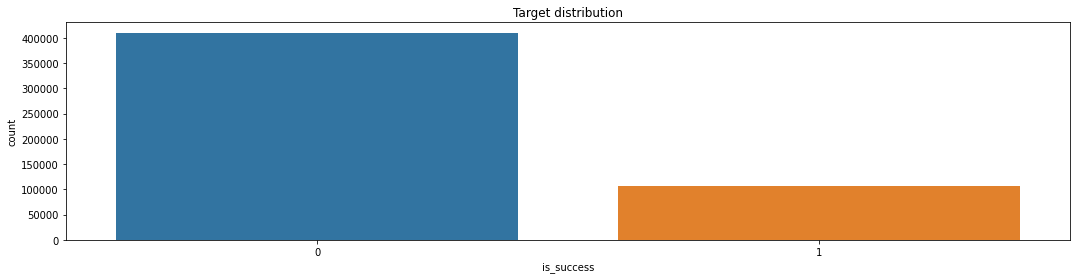

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(18, 4))
sns.countplot(data=df, x='is_success', ax=ax)
ax.set_title('Target distribution')
plt.show()

Таргет крайне не сбалансирован, первое что приходит на ум - нельзя использовать метрику вроде точности. Можно оценивать precision, recall, f1. Также можно попробовать использовать стратегии для несбалансированных выборок - undersampling, oversampling, комбинированные решения. 

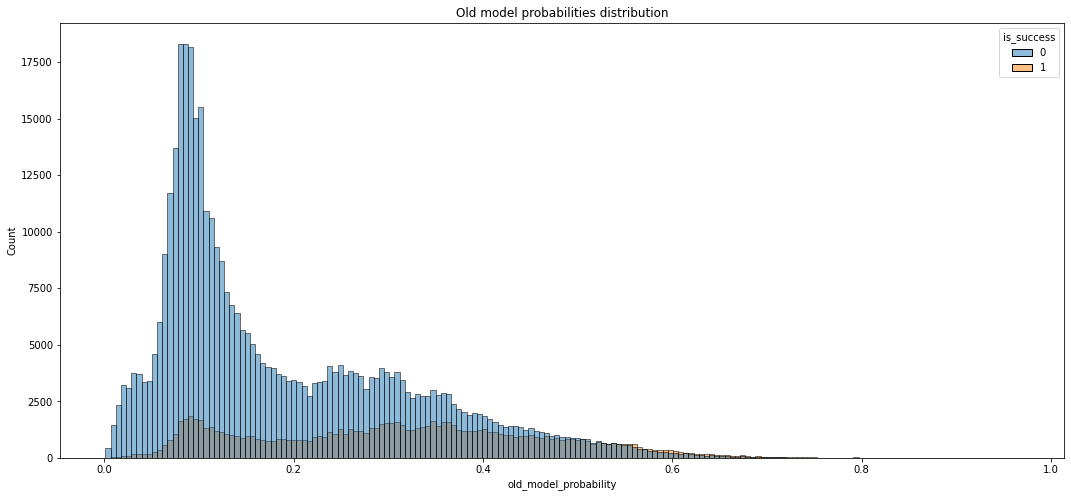

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
sns.histplot(data=df, x='old_model_probability', ax=ax, hue='is_success')
ax.set_title('Old model probabilities distribution')
plt.show()

In [99]:
threshold = 0.5
old_model_probability = df.old_model_probability.values

targets = df.is_success.values
old_model_predictions = np.array(old_model_probability > 0.5, dtype='int8')

acc = accuracy_score(targets, old_model_predictions)
precision = precision_score(targets, old_model_predictions)
recall = recall_score(targets, old_model_predictions)
f1 = f1_score(targets, old_model_predictions)
roc_auc = roc_auc_score(targets, old_model_predictions)

print('Old model accuracy: ', acc)
print('Old model precision: ', precision)
print('Old model recall: ', recall)
print('Old model f1: ', f1)
print('Old model roc_auc: ', roc_auc)

Old model accuracy:  0.7974311286760433
Old model precision:  0.5280912269548633
Old model recall:  0.12541518834453083
Old model f1:  0.20269322271701337
Old model roc_auc:  0.5482306509927743


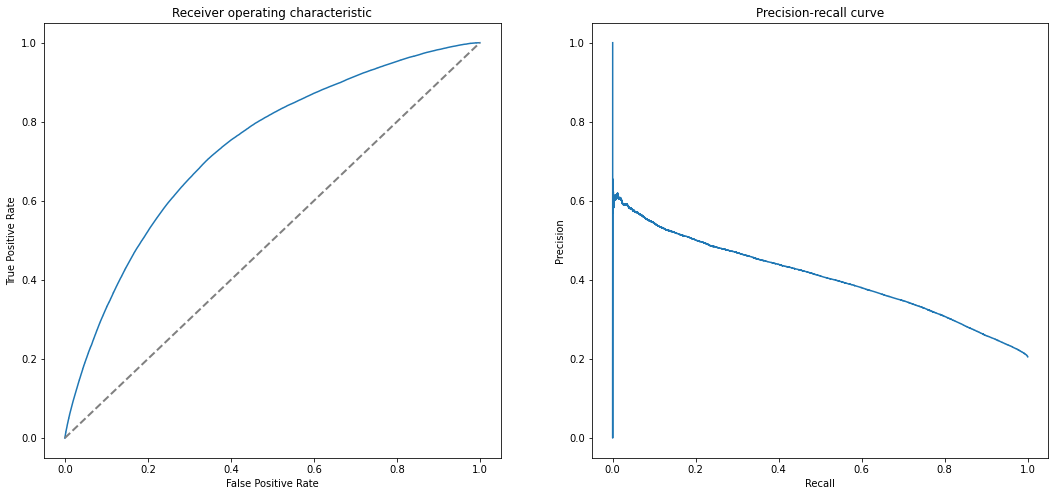

In [126]:
fpr, tpr, _ = roc_curve(targets, old_model_probability)
precision, recall, _ = precision_recall_curve(targets, old_model_probability)

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

axs[0].plot(fpr, tpr)
axs[0].plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
axs[0].set_title('Receiver operating characteristic')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')

axs[1].plot(recall, precision)
axs[1].set_title('Precision-recall curve')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
plt.show()